In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

# Data preperation

In [2]:
df = pd.read_csv('Dataset-SolarTechLab.csv', sep=';', parse_dates=['Time'], index_col='Time')

In [3]:
df.head()

,PV_Power,T_air,G_h,G_tilt,W_s,W_d
Time,,,,,,
2017-01-01 00:00:00,NaN,0.74,0.0,0.0,0.30,296.4
2017-01-01 00:01:00,NaN,0.67,0.0,0.0,0.47,269.2
2017-01-01 00:02:00,NaN,0.57,0.0,0.0,0.84,265.3
2017-01-01 00:03:00,NaN,0.53,0.0,0.0,0.63,275.4
2017-01-01 00:04:00,NaN,0.53,0.0,0.0,0.58,265.3


## Filter out the outliers

In [4]:
# Compute 25th and 75th percentiles for each column
q1 = df.quantile(0.25)
q3 = df.quantile(0.75)

# Compute IQR for each column
iqr = q3 - q1

# Define bounds for filtering outliers
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter rows based on bounds
df = df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]

## Resampling the data for 1h steps

<Axes: xlabel='Time', ylabel='PV_Power'>

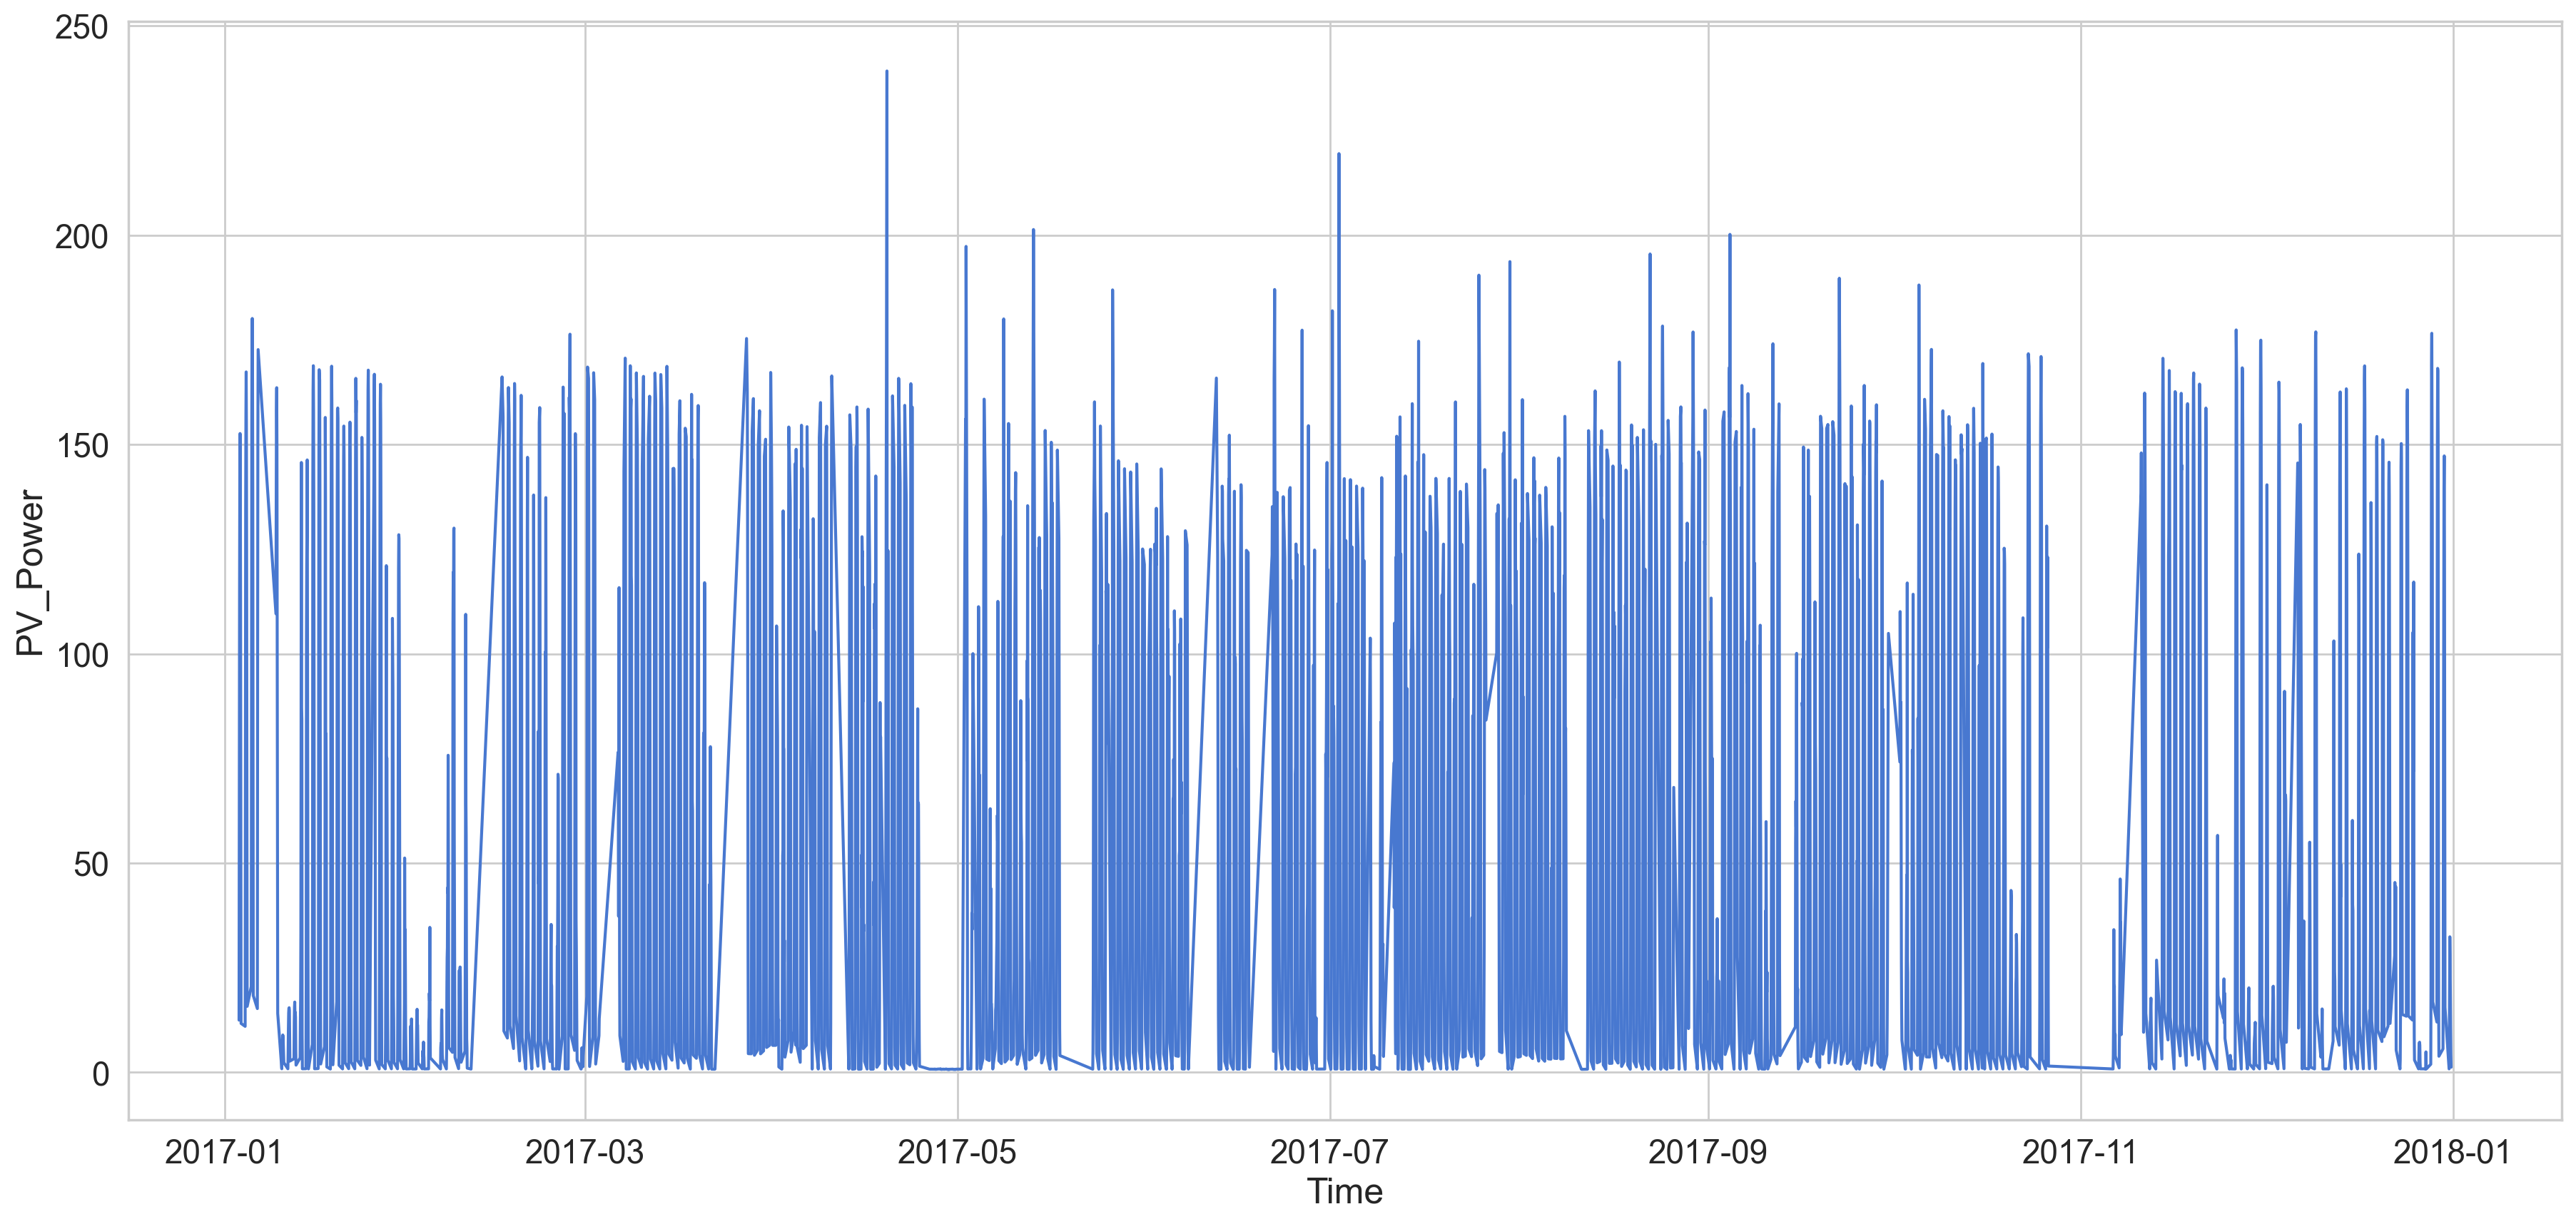

In [5]:
df_by_hour = df.resample('1H').mean()
sns.lineplot(x=df_by_hour.index, y='PV_Power', data=df_by_hour)

## Imputing missing values

In [6]:
df_by_hour.isna().sum()

PV_Power    5346
T_air        507
G_h          507
G_tilt       507
W_s          507
W_d          507
dtype: int64

We have quite a lot of missing data points. We are going to imputet these with a MICE imputer.

In [7]:
# Imputing with MICE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model

df_by_hour_mice = df_by_hour.filter(['Time','PV_Power', 'T_air', 'G_h', 'G_tilt', 'W_s', 'W_d'], axis=1).copy()

# Define MICE Imputer and fill missing values
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')

df_by_hour_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df_by_hour_mice), columns=df_by_hour_mice.columns)
df_by_hour_mice_imputed.index = df_by_hour.index
df_by_hour_mice_imputed.head()

/Users/greg/anaconda3/lib/python3.10/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,PV_Power,T_air,G_h,G_tilt,W_s,W_d
Time,,,,,,
2017-01-01 00:00:00,1.055644,0.791833,0.0,0.0,0.291333,286.755000
2017-01-01 01:00:00,0.450760,0.366833,0.0,0.0,0.351333,162.585000
2017-01-01 02:00:00,0.920027,0.158167,0.0,0.0,0.187833,272.215000
2017-01-01 03:00:00,0.826160,-0.029167,0.0,0.0,0.262500,255.946667
2017-01-01 04:00:00,1.031269,-0.210000,0.0,0.0,0.238833,306.080000


In [8]:
df_by_hour_mice_imputed.isna().sum()

PV_Power    0
T_air       0
G_h         0
G_tilt      0
W_s         0
W_d         0
dtype: int64

Looks good. Let's plot it.

<Axes: xlabel='Time', ylabel='PV_Power'>

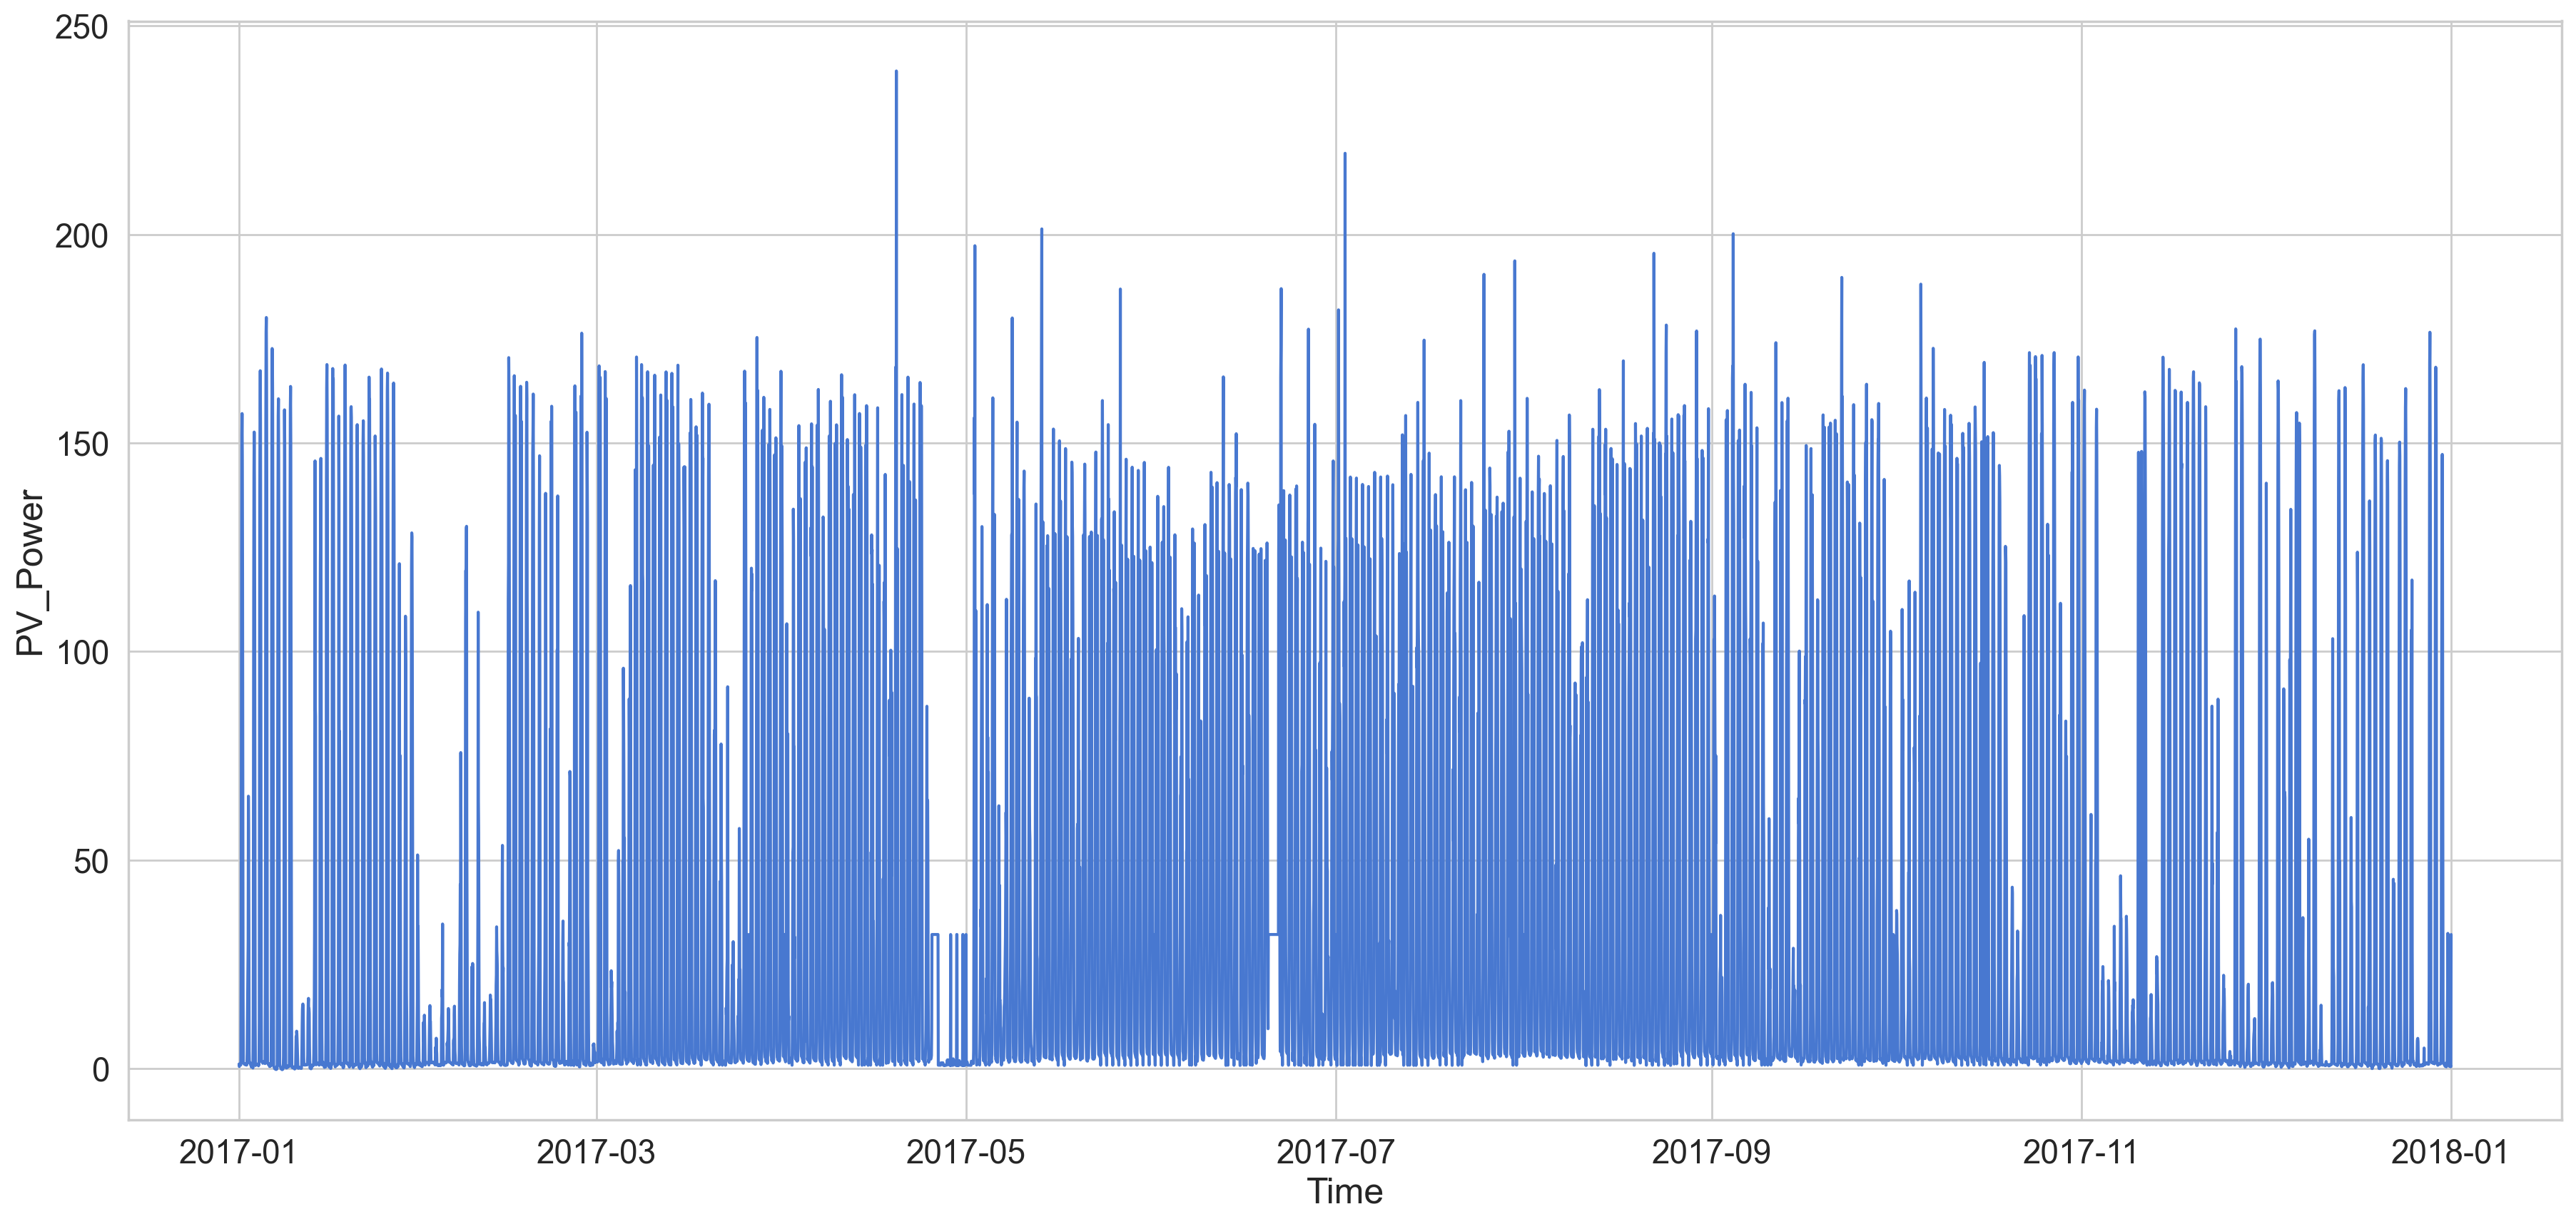

In [9]:
df_by_hour = df_by_hour_mice_imputed
sns.lineplot(x=df_by_hour.index, y='PV_Power', data=df_by_hour)

In [10]:
df_by_hour.describe()

,PV_Power,T_air,G_h,G_tilt,W_s,W_d
count,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000,8761.000000
mean,32.112125,14.437905,119.018566,137.693896,1.218190,185.376251
std,47.420118,8.298348,175.958886,209.436971,0.742744,66.009805
min,-0.284900,-3.712373,0.000000,0.000000,0.000000,31.928333
25%,1.625401,7.699333,0.000000,0.000000,0.584167,125.676667
50%,3.488836,14.437905,7.116667,6.483333,1.193167,197.828333
75%,41.028731,21.035833,180.050000,190.416667,1.732241,243.827119
max,239.213310,36.263833,663.000000,755.000000,3.633333,357.900000


In [11]:
df_by_hour = df_by_hour.query('PV_Power >= 0')

In [13]:
df_by_hour.describe()

,PV_Power,T_air,G_h,G_tilt,W_s,W_d
count,8729.000000,8729.000000,8729.000000,8729.000000,8729.000000,8729.000000
mean,32.230252,14.494885,119.454707,138.198584,1.218748,185.788413
std,47.466738,8.259742,176.133362,209.654293,0.743633,65.772730
min,0.003306,-3.712373,0.000000,0.000000,0.000000,31.928333
25%,1.637183,7.783000,0.000000,0.000000,0.583500,126.746667
50%,3.522455,14.437905,7.830508,7.133333,1.194167,198.324000
75%,41.426745,21.070500,180.900000,192.183333,1.735094,243.923333
max,239.213310,36.263833,663.000000,755.000000,3.633333,357.900000


# Saving the cleaned dataset

In [12]:
df_by_hour.to_csv('cleaned_data.csv')

Now we can continue with the EDA and training models.